In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle, os, pwd
import seaborn as sns
import histlite as hl
from matplotlib.lines import Line2D
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import UnivariateSpline

import csky as cy

mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

In [3]:
timer = cy.timing.Timer()
time = timer.time

In [4]:
username = pwd.getpwuid(os.getuid())[0]
ana_dir = cy.utils.ensure_dir(f'/home/{username}/csky_cache')

try:
    ana = cy.get_analysis(cy.selections.repo, cy.selections.PSDataSpecs.IC86v4, dir=ana_dir)
    ana.save(ana_dir)
except:
    ana = cy.get_analysis(cy.selections.repo, cy.selections.PSDataSpecs.IC86v4)

cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 5

Setting up Analysis for:
IC86v4
Setting up IC86v4...
Reading /data/ana/analyses/ps_tracks/current/IC86_2016_MC.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2011_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2012_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2013_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2014_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2015_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2016_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2017_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2018_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/IC86_2019_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/ps_tracks/current/GRL/IC86_2014_exp.np

In [5]:
src = cy.sources(0.0, 30.0, deg=True)
tr = cy.get_trial_runner(src=src)

In [6]:
with time('ps bg trials'):
    n_trials = 1000
    bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 1000 background trials using 5 cores:
       1000/1000 trials complete.   

0:00:15.298750 elapsed.


/home/apizzuto/.venvs/py3_realtime/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


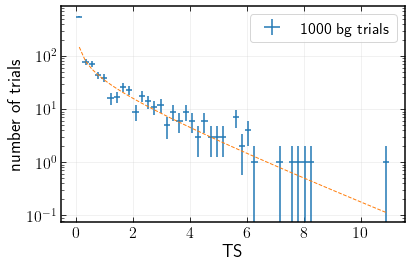

In [7]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials'.format(bg.n_total))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            #label=r'$\chi^2[{:.2f}\text{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta)
           )

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

In [14]:
def calc_power_law_sens(gamma):
    tr = cy.get_trial_runner(
        ana=ana, src=src, 
        flux=cy.hyp.PowerLawFlux(gamma)
    )
    sens = sens = tr.find_n_sig(
        bg.median(),
        0.9,
        n_sig_step=5,
        batch_size=100,
        tol=.05
    )
    return tr.to_E2dNdE(sens, E0=1e5, unit=1)

def calc_one_diff_sens_bin(bin_gamma, low_en, high_en):
    tr = cy.get_trial_runner(
        ana=ana, src=src, 
        flux=cy.hyp.PowerLawFlux(
            bin_gamma, 
            energy_range=(low_en, high_en)
        )
    )
    sens = sens = tr.find_n_sig(
        bg.median(),
        0.9,
        n_sig_step=5,
        batch_size=100,
        tol=.10,
        logging=False
    )
    return tr.to_E2dNdE(sens, E0=low_en, unit=1)

def calc_diff_sens(bins_per_decade=1, low=1e1, high=1e9, 
                   bin_gamma=2., logging=True):
    energy_bins = np.logspace(
        np.log10(low),
        np.log10(high),
        (np.log10(high) - np.log10(low)) * bins_per_decade + 1
    )
    diff_sens = {'bins': energy_bins, 'sens': [], 'gamma': bin_gamma}
    if logging:
        print('Running differential sens calculation')
    for low_en, high_en in zip(energy_bins[:-1], energy_bins[1:]):
        if logging:
            print(f'\t - doing bin from {low_en:.1e} to {high_en:.1e}')
        tmp_diff = calc_one_diff_sens_bin(bin_gamma, low_en, high_en)
        diff_sens['sens'].append(tmp_diff)
    return diff_sens

In [15]:
res = calc_diff_sens(bins_per_decade=1, low=1e2, high=1e7, bin_gamma=2.)

Running differential sens calculation
	 - doing bin from 1.0e+02 to 1.0e+03
	 - doing bin from 1.0e+03 to 1.0e+04
	 - doing bin from 1.0e+04 to 1.0e+05
	 - doing bin from 1.0e+05 to 1.0e+06
	 - doing bin from 1.0e+06 to 1.0e+07


In [91]:
with open('results/tmp_save.pkl', 'wb') as f:
    pickle.dump(res, f)

In [92]:
with open('results/tmp_save.pkl', 'rb') as fi:
    data = pickle.load(fi)
data

{'bins': array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 'sens': [6.790447154688822e-08,
  3.7041028043904296e-09,
  8.476281095898959e-10,
  1.0575529835275884e-09,
  5.05278505088406e-09],
 'gamma': 2.0}

In [22]:
res_2 = calc_diff_sens(bins_per_decade=2, low=1e2, high=1e7, bin_gamma=2.)
res_gamma_25 = calc_diff_sens(bins_per_decade=2, low=1e2, high=1e7, bin_gamma=2.5)
res_gamma_3 = calc_diff_sens(bins_per_decade=2, low=1e2, high=1e7, bin_gamma=3.)

Running differential sens calculation
	 - doing bin from 1.0e+02 to 3.2e+02
	 - doing bin from 3.2e+02 to 1.0e+03
	 - doing bin from 1.0e+03 to 3.2e+03
	 - doing bin from 3.2e+03 to 1.0e+04
	 - doing bin from 1.0e+04 to 3.2e+04
	 - doing bin from 3.2e+04 to 1.0e+05
	 - doing bin from 1.0e+05 to 3.2e+05
	 - doing bin from 3.2e+05 to 1.0e+06
	 - doing bin from 1.0e+06 to 3.2e+06
	 - doing bin from 3.2e+06 to 1.0e+07
Running differential sens calculation
	 - doing bin from 1.0e+02 to 3.2e+02
	 - doing bin from 3.2e+02 to 1.0e+03
	 - doing bin from 1.0e+03 to 3.2e+03
	 - doing bin from 3.2e+03 to 1.0e+04
	 - doing bin from 1.0e+04 to 3.2e+04
	 - doing bin from 3.2e+04 to 1.0e+05
	 - doing bin from 1.0e+05 to 3.2e+05
	 - doing bin from 3.2e+05 to 1.0e+06
	 - doing bin from 1.0e+06 to 3.2e+06
	 - doing bin from 3.2e+06 to 1.0e+07
Running differential sens calculation
	 - doing bin from 1.0e+02 to 3.2e+02
	 - doing bin from 3.2e+02 to 1.0e+03
	 - doing bin from 1.0e+03 to 3.2e+03
	 - doing bi

In [23]:
def plot_differential_sens(diff_sens, color=sns.xkcd_rgb['battleship grey']):
    for low_e, high_e, sens in zip(diff_sens['bins'][:-1],
                                  diff_sens['bins'][1:],
                                  diff_sens['sens']):
        plt.plot(
            [low_e, high_e], 
            [sens, sens*(high_e/low_e)**(2.-diff_sens['gamma'])],
            color=color
        )

In [28]:
res_2['gamma'] = 2.
res_gamma_25['gamma'] = 2.5
res_gamma_3['gamma'] = 3.

In [24]:
palette = sns.color_palette('colorblind')

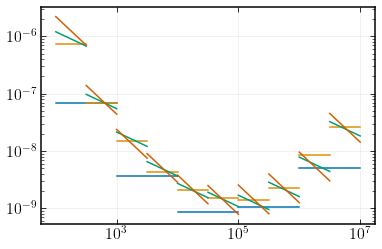

In [29]:
for ii, tmp in enumerate([res, res_2, res_gamma_25, res_gamma_3]):
    plot_differential_sens(tmp, color=palette[ii])
    
plt.loglog()
plt.show()

In [51]:
def load_model(name='Crab_lowen'):
    tmp = np.loadtxt(f'ps_models/{name}.csv', delimiter=', ')
    ens = tmp.T[0]
    fls = tmp.T[1] * 1e3 # From TeV cm^-2 s^-1 to GeV cm^-2 s^-1
    return ens, fls

def make_log_spline(name='Crab_lowen'):
    ens, fls = load_model(name=name)
    log_e = np.log10(ens)
    log_f = np.log10(fls)
    log_spl = PchipInterpolator(log_e, log_f)
    return log_spl

def make_model_spline(name='Crab_lowen'):
    log_spl = make_log_spline(name=name)
    spl = lambda e: 10.**(log_spl(np.log10(e)))
    return spl

def make_all_splines():
    model_splines = dict()
    for name in ['3C273', 'Crab_highen', 
                 'Crab_lowen', 'G40_5-0_5', 
                 'Mrk421']:
        ens, fls = load_model(name=name)
        model_splines[name] = {'spl': make_model_spline(name=name),
                               'low_e': np.min(ens),
                               'high_e': np.max(ens)}
    return model_splines

model_splines = make_all_splines()

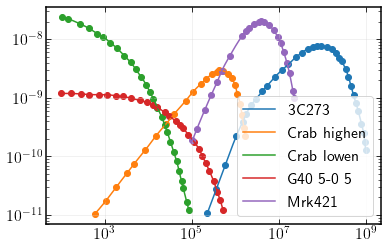

In [52]:
for name, model in model_splines.items():
    es = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        500
    )
    plt.plot(es, model['spl'](es), label=name.replace('_', ' '))
    ee, ff = load_model(name=name)
    plt.scatter(ee, ff)
    
plt.loglog()
plt.legend()
plt.show()

In [53]:
for name, model in model_splines.items():
    e_bins = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        51
    )
    mids = 10.**(np.log10(e_bins)[:-1] + np.diff(np.log10(e_bins))/2.)
    binned_flux = model['spl'](mids) / (mids**2) # models are E^2 dN/dE, we want dN/dE
    flux_model = cy.hyp.BinnedFlux(e_bins, binned_flux)
    model_splines[name]['binned_flux'] = flux_model

In [76]:
def get_model_sensitivity(name):
    tr = cy.get_trial_runner(
        ana=ana, src=src, 
        flux=model_splines[name]['binned_flux']
    )
    sens = sens = tr.find_n_sig(
        bg.median(),
        0.9,
        n_sig_step=5,
        batch_size=100,
        tol=.10,
        logging=False
    )
    low_en = model_splines[name]['binned_flux'].bins_energy[0]
    return tr.to_dNdE(sens, E0=low_en, unit=1)

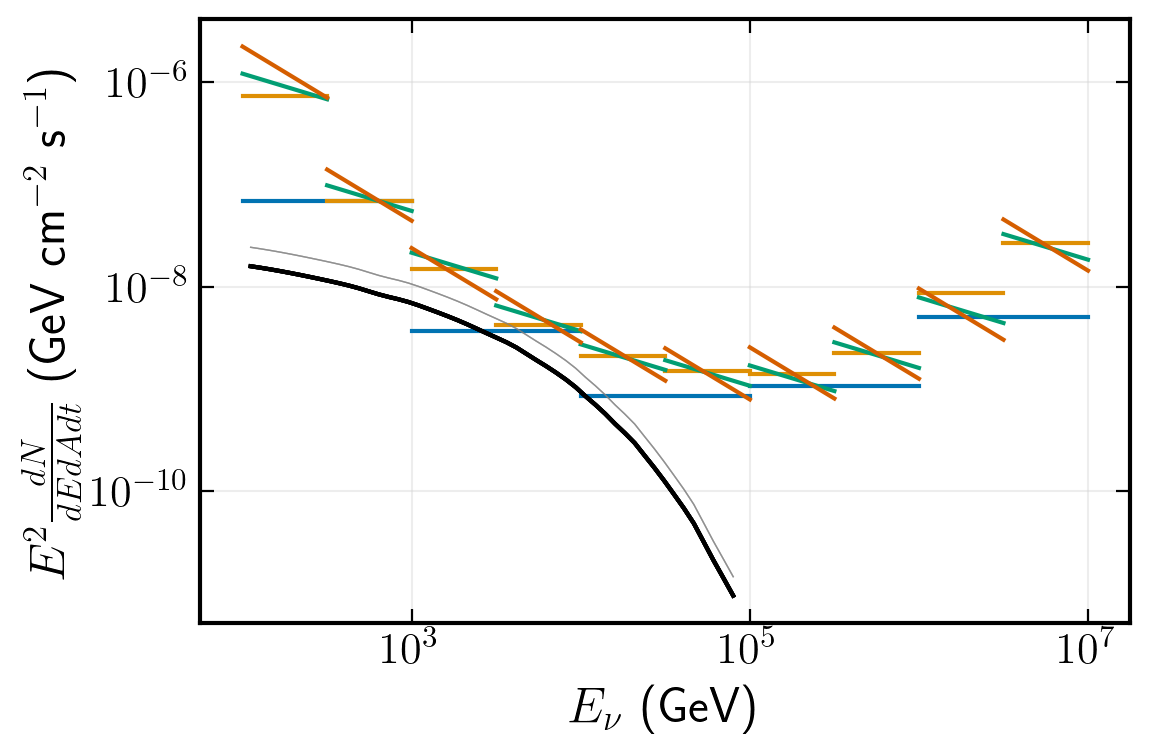

In [90]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)

for ii, tmp in enumerate([res, res_2, res_gamma_25, res_gamma_3]):
    plot_differential_sens(tmp, color=palette[ii])
    name = 'Crab_lowen'
    model = model_splines[name]
    es = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        500
    )
#     plt.plot(es, model['spl'](es), label=name.replace('_', ' '))
    model_es = 10.**(np.log10(model_splines[name]['binned_flux'].bins_energy[:-1]) \
                     + np.diff(np.log10(model_splines[name]['binned_flux'].bins_energy))/2)
    model_fs = model_splines[name]['binned_flux'].flux[:-1]
    sens_fs = model_fs * (crab_sens / model_fs[0])
    
    plt.plot(model_es, model_fs * model_es**2., color='gray', alpha=0.4, lw=0.5)
    plt.plot(model_es, sens_fs * model_es**2., color='k', alpha=1.0)
    
plt.loglog()
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdAdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.grid(True, which='both')
plt.show()

In [77]:
crab_sens = get_model_sensitivity('Crab_lowen')

In [78]:
crab_sens

array([1.26625316e-12])

In [43]:
for name, model in model_splines.items():
    e_bins = np.logspace(
        np.log10(model['low_e']), 
        np.log10(model['high_e']),
        51
    )
    mids = 10.**(np.log10(e_bins)[:-1] + np.diff(np.log10(e_bins))/2.)
    binned_flux = model['spl'](mids)
    flux_model = cy.hyp.BinnedFlux(e_bins, binned_flux)
    model_splines[name]['binned_flux'] = flux_model